In [1]:
%matplotlib inline
import sys
sys.version

'3.7.9 (default, Jan 24 2021, 23:57:56) \n[GCC 10.2.0]'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import json
from matplotlib.ticker import MaxNLocator
import matplotlib

#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

In [3]:
#filename = "../../../long-results/2021-07-03T21:00:21_inv_allIhave_120000_10_600000_120000_24.json"
#filename = "../../../long-results/2021-08-02T16:09:09_inv_singleServerAllGPU_120000_1.0_600000_120000_4.0.json"
#filename = "../../../long-results/2021-08-02T15:36:25_inv_singleServerSingleGPU_120000_0.5_600000_120000_2.5.json"
#filename = "../../../long-results/2021-07-13T16:54:46_inv_singleServerAllVPU_120000_1.0_600000_120000_5.0.json"
filename = "../../../long-results/2021-07-19T19:18:05_inv_allIhaveDoubleBetter_120000_5.0_600000_120000_10.0.json"

images_folder = "../../../eval-images-unfinished/" + filename.split("_")[2] +"/"

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

ps = filename.split("_")
trps = dotdict({
    'p0': int(ps[3])/1000,
    'p0t': float(ps[4]),
    'p1': int(ps[5])/1000,
    'p2': int(ps[6])/1000,
    "p2t": float(ps[7].replace(".json", ""))
})

In [4]:
dict_for_colors = {}
get_counter_of_pid_list = []
available_colors = ['g','r','c','m','y','k']*1000000

def assign_color_to_hostname_pid(hostname, pid) -> str:
    key = hostname + pid
    if not key in dict_for_colors:
        dict_for_colors[key] = available_colors[len(dict_for_colors)]
    return dict_for_colors[key]

def get_uid_of_ri(pid, hostname, accelerator) -> int:
    key = str(pid) + str(hostname) + str(accelerator)
    try:
        val =  get_counter_of_pid_list.index(key)
        return val
    except Exception:
        get_counter_of_pid_list.append(key)
        return get_counter_of_pid_list.index(key)

def accelerator_type_from_accelerator(acc) -> str:
    if acc == "mycpu":
        return "cpu"
    if acc == "0" or acc == "1":
        return "gpu"
    if acc == "main.py": ## I don't understand this either
        return "vpu"

In [5]:
with open(filename) as f:
    d = json.load(f)
data = json_normalize(d)

print(data)

failed = [end == -1 for end in data['end']]
data.insert(0, "failed", failed)

if data.start.min() != 0:
    global experiment_start
    experiment_start = data.start.min()

data.start = data.start - experiment_start
data.end = data.end - experiment_start
data['result.start_computation'] = data['result.start_computation'] - experiment_start
data['result.end_computation'] = data['result.end_computation'] - experiment_start
data['result.metadata.start'] = data['result.metadata.start'] - experiment_start
data['result.metadata.end'] = data['result.metadata.end'] - experiment_start

# End to End Latency
data.insert(0,"rlat",data.end - data.start)

# Distribution Latency - How long was it 
data.insert(0, "dlat", data.rlat - data['result.metadata.inference_ms'])

data.insert(0, "rfast", data.rlat <= 10000)

data

                 end          start       inv.configuration  \
0      1626714155948  1626714149570  test|tinyyolov2-7.onnx   
1      1626714156579  1626714149570  test|tinyyolov2-7.onnx   
2      1626714156272  1626714149570  test|tinyyolov2-7.onnx   
3      1626714157859  1626714149570  test|tinyyolov2-7.onnx   
4      1626714158246  1626714149577  test|tinyyolov2-7.onnx   
...              ...            ...                     ...   
12594  1626714983151  1626714980975  test|tinyyolov2-7.onnx   
12595  1626714983227  1626714980991  test|tinyyolov2-7.onnx   
12596  1626714983432  1626714980955  test|tinyyolov2-7.onnx   
12597  1626714984552  1626714980967  test|tinyyolov2-7.onnx   
12598  1626714983588  1626714980982  test|tinyyolov2-7.onnx   

                    inv.params.callbackUrl inv.params.payload  \
0      localhost:3358/ik5dcOVK5ToQGsvAeyct                      
1      localhost:3358/5KaEcmJnlAdg5SuzcnLz                      
2      localhost:3358/8wLDnPx2s09EM0DGdedE      

,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,True,3980.101088,6378,False,6378,0,test|tinyyolov2-7.onnx,localhost:3358/ik5dcOVK5ToQGsvAeyct,,minio-admin,...,2397.898912,localhost.localdomain,2117.030762,4514.929688,2236932,,[output.bin],reference,1646.0,NaN
1,True,4244.296726,7009,False,7009,0,test|tinyyolov2-7.onnx,localhost:3358/5KaEcmJnlAdg5SuzcnLz,,minio-admin,...,2764.703274,sandybridge-ep,3065.179688,5829.883057,85832,,[output.bin],reference,1865.0,NaN
2,True,6437.970497,6702,False,6702,0,test|tinyyolov2-7.onnx,localhost:3358/8wLDnPx2s09EM0DGdedE,,minio-admin,...,264.029503,localhost.localdomain,6346.505615,6610.535156,2236965,,[output.bin],reference,6344.0,NaN
3,True,8100.599016,8289,False,8289,0,test|tinyyolov2-7.onnx,localhost:3358/7IDGsQBAxGhJwaxt6CGV,,minio-admin,...,188.400984,localhost.localdomain,8032.453369,8220.854492,2236942,,[output.bin],reference,8031.0,NaN
4,True,8467.276424,8669,False,8676,7,test|tinyyolov2-7.onnx,localhost:3358/RG2myEyykzv8Oyb3OtdD,,minio-admin,...,201.723576,localhost.localdomain,8411.937744,8613.661133,2236932,,[output.bin],reference,8409.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594,True,1991.605164,2176,False,833581,831405,test|tinyyolov2-7.onnx,localhost:3358/Qh17C2HZzowX6ESLLqXk,,minio-admin,...,184.394836,localhost.localdomain,833341.933838,833526.328613,2238562,,[output.bin],reference,833340.0,NaN
12595,True,2078.864513,2236,False,833657,831421,test|tinyyolov2-7.onnx,localhost:3358/HuSH2b02P1SA4sumN9YQ,,minio-admin,...,157.135487,localhost.localdomain,833448.915771,833606.051270,2236965,,[output.bin],reference,833447.0,NaN
12596,True,2304.651262,2477,False,833862,831385,test|tinyyolov2-7.onnx,localhost:3358/0S9X3dMIC9ikpxfAjPNT,,minio-admin,...,172.348738,localhost.localdomain,833632.178467,833804.527100,2236965,,[output.bin],reference,833630.0,NaN
12597,True,2326.017818,3585,False,834982,831397,test|tinyyolov2-7.onnx,localhost:3358/iXPqktC14HPJDOlkgSUQ,,minio-admin,...,1258.982182,sandybridge-ep,833667.485596,834926.467773,86575,,[output.bin],reference,833665.0,NaN


In [6]:
print('Number of failed invocations:', len(data.loc[data['failed'] == True].index))
data.loc[data['failed'] == True]

Number of failed invocations: 2


,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
995,True,NaN,-1626714210440,True,-1626714149571,60869,test|tinyyolov2-7.onnx,localhost:3358/viS04lP6EImLKm9RJsiF,,minio-admin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9863,True,NaN,-1626714800645,True,-1626714149571,651074,test|tinyyolov2-7.onnx,localhost:3358/7DeDWbJwrD0k5tMBQ677,,minio-admin,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data = data.loc[data['failed'] == False]
data

,rfast,dlat,rlat,failed,end,start,inv.configuration,inv.params.callbackUrl,inv.params.payload,inv.params.payload_reference.bucket.accessKey,...,result.metadata.inference_ms,result.metadata.hostname,result.metadata.start,result.metadata.end,result.pid,result.request,result.result,result.result_type,result.start_computation,result
0,True,3980.101088,6378,False,6378,0,test|tinyyolov2-7.onnx,localhost:3358/ik5dcOVK5ToQGsvAeyct,,minio-admin,...,2397.898912,localhost.localdomain,2117.030762,4514.929688,2236932,,[output.bin],reference,1646.0,NaN
1,True,4244.296726,7009,False,7009,0,test|tinyyolov2-7.onnx,localhost:3358/5KaEcmJnlAdg5SuzcnLz,,minio-admin,...,2764.703274,sandybridge-ep,3065.179688,5829.883057,85832,,[output.bin],reference,1865.0,NaN
2,True,6437.970497,6702,False,6702,0,test|tinyyolov2-7.onnx,localhost:3358/8wLDnPx2s09EM0DGdedE,,minio-admin,...,264.029503,localhost.localdomain,6346.505615,6610.535156,2236965,,[output.bin],reference,6344.0,NaN
3,True,8100.599016,8289,False,8289,0,test|tinyyolov2-7.onnx,localhost:3358/7IDGsQBAxGhJwaxt6CGV,,minio-admin,...,188.400984,localhost.localdomain,8032.453369,8220.854492,2236942,,[output.bin],reference,8031.0,NaN
4,True,8467.276424,8669,False,8676,7,test|tinyyolov2-7.onnx,localhost:3358/RG2myEyykzv8Oyb3OtdD,,minio-admin,...,201.723576,localhost.localdomain,8411.937744,8613.661133,2236932,,[output.bin],reference,8409.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12594,True,1991.605164,2176,False,833581,831405,test|tinyyolov2-7.onnx,localhost:3358/Qh17C2HZzowX6ESLLqXk,,minio-admin,...,184.394836,localhost.localdomain,833341.933838,833526.328613,2238562,,[output.bin],reference,833340.0,NaN
12595,True,2078.864513,2236,False,833657,831421,test|tinyyolov2-7.onnx,localhost:3358/HuSH2b02P1SA4sumN9YQ,,minio-admin,...,157.135487,localhost.localdomain,833448.915771,833606.051270,2236965,,[output.bin],reference,833447.0,NaN
12596,True,2304.651262,2477,False,833862,831385,test|tinyyolov2-7.onnx,localhost:3358/0S9X3dMIC9ikpxfAjPNT,,minio-admin,...,172.348738,localhost.localdomain,833632.178467,833804.527100,2236965,,[output.bin],reference,833630.0,NaN
12597,True,2326.017818,3585,False,834982,831397,test|tinyyolov2-7.onnx,localhost:3358/iXPqktC14HPJDOlkgSUQ,,minio-admin,...,1258.982182,sandybridge-ep,833667.485596,834926.467773,86575,,[output.bin],reference,833665.0,NaN


In [8]:
# (semi-)unique color per runtime instance
acc_color = [assign_color_to_hostname_pid(hostname, pid) for hostname,pid in zip(data['result.metadata.hostname'], data['result.pid'])]
data.insert(0,"acc_color", acc_color)

# unique id for every pid, starting with 0 (may be used as y-axis in some images)
inst_id = [get_uid_of_ri(pid, hn, acc) for pid,hn,acc in zip(data['result.pid'],data['result.metadata.hostname'],data['result.accelerator'])]
data.insert(0, "inst_id", inst_id)

# String that identifies the type of accelerator
acc_type = [accelerator_type_from_accelerator(acc) for acc in data['result.accelerator']]
data.insert(0, "acc_type", acc_type)

acc_name = [str(hn) + "-" + str(acc) for hn,acc in zip(data['result.metadata.hostname'], data['result.accelerator'])]
data.insert(0, "acc_name", acc_name)

In [9]:
data.columns

Index(['acc_name', 'acc_type', 'inst_id', 'acc_color', 'rfast', 'dlat', 'rlat',
       'failed', 'end', 'start', 'inv.configuration', 'inv.params.callbackUrl',
       'inv.params.payload', 'inv.params.payload_reference.bucket.accessKey',
       'inv.params.payload_reference.bucket.bucketName',
       'inv.params.payload_reference.bucket.endpoint',
       'inv.params.payload_reference.bucket.secretKey',
       'inv.params.payload_reference.file', 'inv.params.payload_type',
       'inv.params.resultBucket.accessKey',
       'inv.params.resultBucket.bucketName',
       'inv.params.resultBucket.endpoint', 'inv.params.resultBucket.secretKey',
       'inv.runtime', 'result.accelerator', 'result.amount',
       'result.end_computation', 'result.metadata.inference_ms',
       'result.metadata.hostname', 'result.metadata.start',
       'result.metadata.end', 'result.pid', 'result.request', 'result.result',
       'result.result_type', 'result.start_computation', 'result'],
      dtype='object')

In [10]:
def print_stats(df):
    print(f'Total requests: {df.shape[0]}')
    inf = df['result.metadata.inference_ms']
    print(f'Inference: mean={inf.mean()}, std={inf.std()}')
    print(f'Total Duration: mean={df.rlat.mean()}, std={df.rlat.std()}')
    com = df['result.end_computation'] - df['result.start_computation']
    print(f'Total Computation (inference+upload): mean={com.mean()}, std={com.std()}')
    tts = df['result.start_computation'] - df.start
    print(f'Time from invocation to start_computation: mean={tts.mean()}, std={tts.std()}')
    percentiles = df[['rlat', 'result.metadata.inference_ms']].describe(percentiles=[0.5, 0.90,0.99])
    print(f'Percentiles for RLat and ELat:')
    print(percentiles)
    print()

print('results total: ')
print_stats(data)

hosts = data['result.metadata.hostname'].unique()

for host in hosts:
    print(f'results for host {host}: ')
    print_stats(data.loc[data['result.metadata.hostname'] == host])
    
print(f'resulsts for system A')
print_stats(data.loc[data['result.metadata.hostname'] != 'localhost.localdomain'])
                     
print(f'resulsts for system B')
print_stats(data.loc[data['result.metadata.hostname'] == 'localhost.localdomain'])

print(f'resulsts for GPUs')
print_stats(data.loc[data["acc_type"] == 'gpu'])

print(f'resulsts for VPUs')
print_stats(data.loc[data["acc_type"] != 'gpu'])
    


#print('results home: ')
#print_stats(data.loc[data['result.metadata.hostname'] != 'sandybridge-ep'])

results total: 
Total requests: 12597
Inference: mean=392.9699546450271, std=571.7907841439219
Total Duration: mean=5343.647773279352, std=4334.147226706764
Total Computation (inference+upload): mean=398.85544177185045, std=583.0840889273167
Time from invocation to start_computation: mean=4887.014765420338, std=4376.998307240444
Percentiles for RLat and ELat:
               rlat  result.metadata.inference_ms
count  12597.000000                  12597.000000
mean    5343.647773                    392.969955
std     4334.147227                    571.790784
min      168.000000                     84.616184
50%     4080.000000                    165.931225
90%    10912.800000                   1558.177376
99%    19920.120000                   2059.038630
max    24566.000000                   4484.508514

results for host localhost.localdomain: 
Total requests: 10363
Inference: mean=144.56453972613733, std=73.67947923315879
Total Duration: mean=5191.541638521664, std=4321.529272750407
Tota

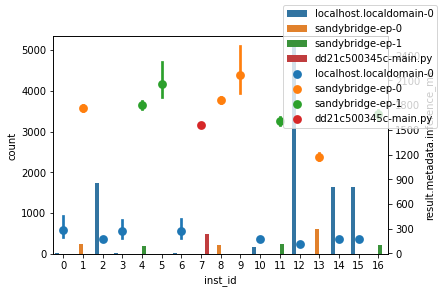

In [11]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("ELat [ms]")
ax.set_xlabel("Time since start [s]")
sns.countplot(ax=ax, data=data, x='inst_id', hue='acc_name')
ax.get_legend().remove()

ax2 = ax.twinx()
ax2.set_ylabel("Requests computed [\#]")
sns.pointplot(ax=ax2, data=data, x='inst_id', y='result.metadata.inference_ms', hue='acc_name', join=False)
ax2.get_legend().remove()
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.legend(loc="upper right")

Used Runtime Instances and when they were active


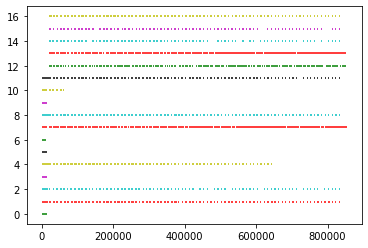

In [12]:
plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=data.acc_color, linestyle="solid")
#plt.scatter(data.start, data.inst_id)
print("Used Runtime Instances and when they were active")

In [13]:
def generate_seconds(data, rstart=False):
    # Plot by RStart
    min, max = 0, 0
    if rstart:
        max = int(data.start.max() / 1000) # Rounds down to the latest second
        min = 0 # Per definition for the start
    else:
        # Plot by EStart
        max = int(data['result.start_computation'].max() / 1000)
        min = int(data['result.start_computation'].min() / 1000)
    data_smooth = data.rolling(1000, min_periods=1).mean()

    seconds_d = {
        # Request-Response Latency
        'rlat_min': [],
        'rlat_med': [],
        'rlat_max': [],
        # Execution Start-End Latency
        'elat_min': [],
        'elat_med': [],
        'elat_max': [],
        # Number of successful invocations
        'rsuccess': [],
        #'rfast_min': [],
        'rfast_avg': [],
        #'rfast_max': []
    }

    for i in range(min, max):
        t_min = i * 1000
        t_max = (i+1) * 1000
        # For Host Selection:
        # (data['result.metadata.hostname'] != 'sandybridge-ep') & 
        # Plot by RStart
        curr, curr_smooth = {}, {}
        if rstart:
            curr = data.loc[(data.start >= t_min) & (data.start < t_max)]
            curr_smooth = data_smooth.loc[(data.start >= t_min) & (data.start < t_max)]
        else:
        # Plot by EStart
            curr = data.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
            curr_smooth = data_smooth.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_max)]
        seconds_d['rlat_min'].append(curr.rlat.min())
        seconds_d['rlat_med'].append(curr.rlat.median())
        seconds_d['rlat_max'].append(curr.rlat.max())

        seconds_d['elat_min'].append(curr['result.metadata.inference_ms'].min())
        seconds_d['elat_med'].append(curr['result.metadata.inference_ms'].median())
        seconds_d['elat_max'].append(curr['result.metadata.inference_ms'].max())
        
        next10s = []
        if rstart:
            next10s = data.loc[(data.start >= t_min) & (data.start < t_min + 10000)]
        else:
        # Plot by EStart
            next10s = data.loc[(data['result.start_computation'] >= t_min) & (data['result.start_computation'] < t_min+10000)]

        #next10s = data.loc[(data.start >= t_min) & (data.start < t_min + 10000)]
        seconds_d['rsuccess'].append(next10s.shape[0]/10)
        #seconds_d['rfast_min'].append(next10s.loc[next10s['rfast']].min())
        seconds_d['rfast_avg'].append(next10s.loc[next10s['rfast']].shape[0]/10)
        #seconds_d['rfast_max'].append(next10s.loc[next10s['rfast']].max())

    seconds = pd.DataFrame(seconds_d)
    seconds_smooth = seconds.rolling(10, min_periods=1).mean()
    return seconds, seconds_smooth
seconds, seconds_smooth = generate_seconds(data, False)

In [14]:
def plot_seconds(data):
    fig = plt.figure(figsize=(5.4, 3.6))
    ax = plt.axes()
    ax.set_ylabel("Latency [ms]")
    ax.set_xlabel("Time since start [s]")
    rlat = sns.lineplot(ax=ax, data=data, x=data.index, y='rlat_med', label="RLat")
    elat = sns.lineplot(ax=ax, data=data, x=data.index, y='elat_med', label="ELat")
    rlats = ax.fill_between(data.index, data['rlat_min'], data['rlat_max'], alpha=0.4)
    elats = ax.fill_between(data.index, data['elat_max'], data['elat_min'], alpha=0.4)
    ax.get_legend().remove()

    ax2 = ax.twinx()
    ax2.set_ylabel("Requests/s [\#]")
    rsuc = sns.lineplot(ax=ax2, data=data, x=data.index, y='rsuccess', label="RSuccess", color="darkgreen", alpha=0.6)
    rfast = sns.lineplot(ax=ax2, data=data, x=data.index, y='rfast_avg', label="RFast", color="crimson", alpha=0.6)
    ##ax2.fill_between(x=data.index, y1=data['rfast_min'], y2=data['rfast_max'], alpha=0.4)
    test  = sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="k", label="Test plan", alpha=0.6)
    
    # For the other way around
    test2 = sns.lineplot(ax=ax2, x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p2t, trps.p2t, trps.p0t, trps.p0t], color="dimgray", label="Opp. test plan", alpha=0.6)
    
    ax2.get_legend().remove()
    #ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    plt.legend(handles,labels, loc='upper left')

    #plt.legend()#bbox_to_anchor=(1, 1), borderaxespad=0) #loc="upper right")#,
    plt.tight_layout()

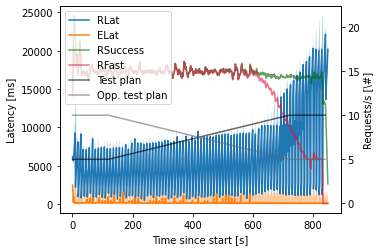

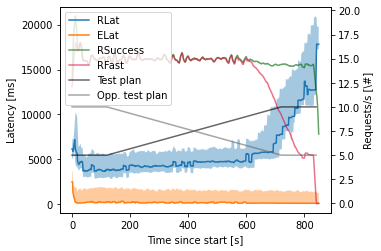

In [15]:
# .loc[(seconds['rlat_min'] > 0) & (seconds['rlat_min'] < 150000)] to see error bars
plot_seconds(seconds)
#plt.savefig(images_folder + "latency.pgf", dpi=1200)
plot_seconds(seconds_smooth)
#plt.savefig(images_folder + "latency_smooth.pgf", dpi=1200)

Statistics while RFast ~= RSuccess
Total requests: 6898
Inference: mean=426.8738635556184, std=607.6873281841761
Total Duration: mean=4042.5953899681067, std=2238.483304856984
Total Computation (inference+upload): mean=435.0439257755871, std=626.2928696271542
Time from invocation to start_computation: mean=3546.27051319223, std=2246.366474684226
Percentiles for RLat and ELat:
               rlat  result.metadata.inference_ms
count   6898.000000                   6898.000000
mean    4042.595390                    426.873864
std     2238.483305                    607.687328
min      168.000000                     84.636211
50%     3800.000000                    172.988296
90%     7275.000000                   1634.191942
99%     9143.330000                   2079.828653
max    14011.000000                   4484.508514

RFast resulsts for system A
Total requests: 1230
Inference: mean=1664.8677634029855, std=411.7116936271219
Total Duration: mean=4798.546341463415, std=2324.2620325205476


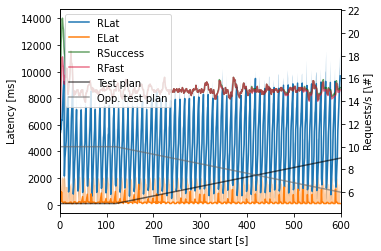

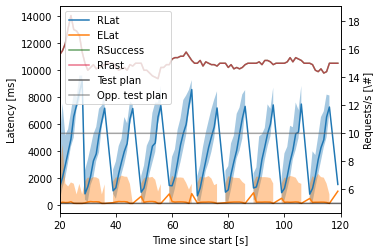

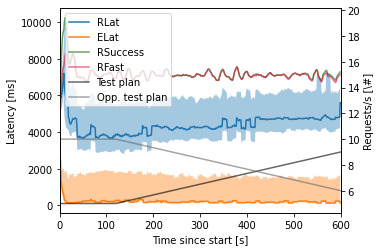

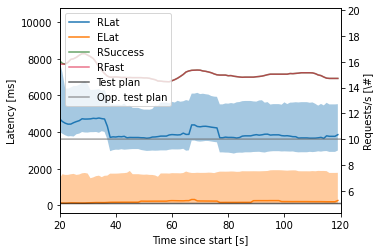

In [16]:

if True:
    # 0:120 => p0
    # singleGPU
    #trfast = 420 
    # allGPU
    #trfast = 520
    # allIHave
    #trfast = 620
    # allVPU
    #trfast = 530
    # double
    trfast = 600
    plot_seconds(seconds.iloc[0:trfast])
    plt.xlim(0, trfast)
    #plt.savefig(images_folder + "latency_untillost.pgf", dpi=1200)
    
    plot_seconds(seconds.iloc[10:120])
    plt.xlim(20, 120)
    #plt.savefig(images_folder + "latency_p0.pgf", dpi=1200)
    
    plot_seconds(seconds_smooth.iloc[0:trfast])
    plt.xlim(0, trfast)
    #plt.savefig(images_folder + "latency_untillost_smooth.pgf", dpi=1200)
    
    plot_seconds(seconds_smooth.iloc[10:120])
    plt.xlim(20, 120)
    #plt.savefig(images_folder + "latency_p0_smooth.pgf", dpi=1200)
# singleGPU
#showrfast = 360
# dualGPU
#showrfast = 480
# allVPU
showrfast = 460 
# allIHave
#showrfast = 600
# double
#showrfast = 600

rfast= data.loc[data['result.start_computation'] <= showrfast*1000]
print('Statistics while RFast ~= RSuccess')
print_stats(rfast)

print(f'RFast resulsts for system A')
print_stats(rfast.loc[rfast['result.metadata.hostname'] != 'localhost.localdomain'])
                     
print(f'RFast resulsts for system B')
print_stats(rfast.loc[rfast['result.metadata.hostname'] == 'localhost.localdomain'])

print(f'RFast resulsts for GPUs')
print_stats(rfast.loc[rfast["acc_type"] == 'gpu'])

print(f'RFast resulsts for VPUs')
print_stats(rfast.loc[rfast["acc_type"] != 'gpu'])

In [17]:
# Read the gpu+queue util as well
util = pd.read_pickle(ps[0] + "_stats.pkl")
util['time'] = util['time'] - experiment_start
experiment_dur = data['end'].max() * 1000
util = util.loc[util['time'] > 0]
util = util.loc[util['time'] < experiment_start + experiment_dur]

util['time'] = util['time']/1000 # convert to seconds
#util

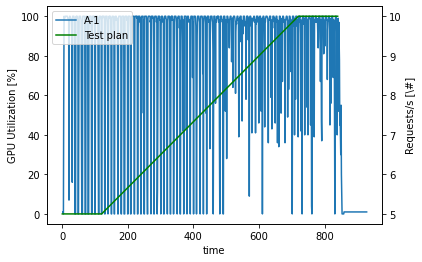

In [18]:
fig = plt.figure()
ax = plt.axes()
ax.set_ylabel("GPU Utilization [%]")

sns.lineplot(ax=ax,data=util, x='time', y='util_gpu1', label="A-1")
#sns.lineplot(ax=ax,data=util, x='time', y='util_gpu2', label="A-2")
#sns.lineplot(ax=ax,data=util, x='time', y='queued', label="Queued invocations")
#sns.lineplot(ax=ax,data=util, x='time', y='util_gpu3', label="B-1")
ax.get_legend().remove()


ax2 = ax.twinx()
ax2.set_ylabel("Requests/s [\#]")
sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="g", label="Test plan")
#plt.savefig('../../../eval-images/example/gpu_nosmooth.pgf')
handles,labels = [],[]
for ax in fig.axes:
    for h,l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)

plt.legend(handles,labels)
#plt.savefig("../../../eval-images/example/gpu_nosmooth.png", dpi=1200)

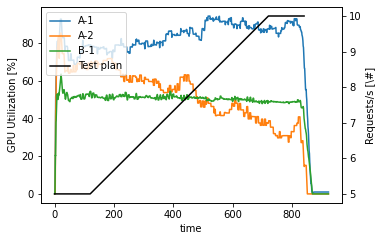

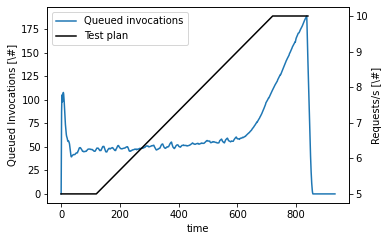

In [19]:
if True:
    # singleGPU
    #endpoint = util.shape[0]
    # allGPU
    #endpoint = 950
    # allIHave
    #endpoint = util.shape[0]
    # allVPU
    #endpoint = util.shape[0]
    # double
    endpoint = util.shape[0]
    
    rolling = util[0:endpoint].rolling(30, min_periods=1).mean()
    # 30 for allGPU
    fig = plt.figure(figsize=(5.4, 3.6))
    ax = plt.axes()
    ax.set_ylabel("GPU Utilization [%]")

    sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu1', label="A-1")
    sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu2', label="A-2")
    sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu3', label="B-1")
    ax.get_legend().remove()

    ax2 = ax.twinx()
    ax2.set_ylabel("Requests/s [\#]")
    sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="black", label="Test plan")

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    plt.legend(handles,labels, loc='upper left')

    #plt.savefig(images_folder + "gpu.pgf", dpi=1200)
    ############################################################################
    rolling = util[0:endpoint].rolling(10, min_periods=1).mean()
    ############################################
    fig = plt.figure(figsize=(5.4, 3.6))
    ax = plt.axes()
    ax.set_ylabel("Queued Invocations [\#]")

    #sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu1', label="A-1")
    #sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu2', label="A-2")
    sns.lineplot(ax=ax,data=rolling, x='time', y='queued', label="Queued invocations")
    #sns.lineplot(ax=ax,data=rolling, x='time', y='util_gpu3', label="B-1", color="y")
    ax.get_legend().remove()

    ax2 = ax.twinx()
    ax2.set_ylabel("Requests/s [\#]")
    sns.lineplot(ax=ax2,x=[0,trps.p0,trps.p0+trps.p1,trps.p0+trps.p1+trps.p2], y=[trps.p0t, trps.p0t, trps.p2t, trps.p2t], color="black", label="Test plan")

    handles,labels = [],[]
    for ax in fig.axes:
        for h,l in zip(*ax.get_legend_handles_labels()):
            handles.append(h)
            labels.append(l)

    plt.legend(handles,labels, loc='upper left')

    #plt.savefig(images_folder + "queue.pgf", dpi=1200)

In [20]:
util.loc[util['util_gpu1'] > 0]

,time,util_gpu3,util_mem3,util_gpu1,util_mem1,util_gpu2,util_mem2,queued
4,1.43,0.0,0.0,1.0,0.0,0.0,0.0,72.0
5,2.43,0.0,0.0,1.0,0.0,0.0,0.0,138.0
7,4.43,45.0,8.0,62.0,18.0,11.0,2.0,138.0
8,5.43,49.0,14.0,100.0,18.0,100.0,35.0,127.0
9,6.43,18.0,5.0,99.0,30.0,100.0,20.0,123.0
...,...,...,...,...,...,...,...,...
925,922.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0
927,924.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0
928,925.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0
930,927.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [21]:
## Only applicable for dual
original = data
onnx = data.loc[data['inv.runtime'] == 'onnx']
onnx2 = data.loc[data['inv.runtime'] == 'onnx2']

FileNotFoundError: [Errno 2] No such file or directory: '../../../eval-images-unfinished/allIhaveDoubleBetter/invocations_runtimes.pdf'

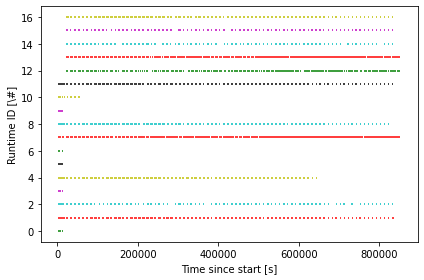

In [22]:
def plot_computation(data, color):
    ax = plt.axes()
    ax.set_ylabel("Runtime ID [\#]")
    ax.set_xlabel("Time since start [s]")
    plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=color, linestyle="solid")
    #plt.legend(handles,labels, loc='upper left')
    #plt.legend()#bbox_to_anchor=(1, 1), borderaxespad=0) #loc="upper right")#,
    plt.tight_layout()

if True:
    plot_computation(data, data['acc_color'])
    plt.savefig(images_folder + "invocations_runtimes.pdf")

    ax = plt.axes()
    ax.set_ylabel("Runtime ID [\#]")
    ax.set_xlabel("Time since start [s]")
    plt.hlines(y=onnx.inst_id, xmin=onnx['result.start_computation'], xmax=onnx['result.end_computation'], colors="g", linestyle="solid")
    plt.hlines(y=onnx2.inst_id, xmin=onnx2['result.start_computation'], xmax=onnx2['result.end_computation'], colors="r", linestyle="solid")
    plt.tight_layout()
    #plt.savefig(images_folder + "invocations_runtimes_opp.pdf")

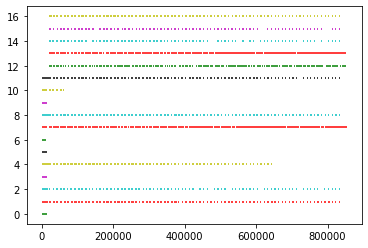

In [23]:

# Two runtimes
if False:
    plt.hlines(y=onnx.inst_id, xmin=onnx['result.start_computation'], xmax=onnx['result.end_computation'], colors="g", linestyle="solid")
    plt.hlines(y=onnx2.inst_id, xmin=onnx2['result.start_computation'], xmax=onnx2['result.end_computation'], colors="r", linestyle="solid")
    #plt.savefig(images_folder + "invocations_runtimes_opp.pgf", dpi=1200)
## Only one runtime
if True:
    plt.hlines(y=data.inst_id, xmin=data['result.start_computation'], xmax=data['result.end_computation'], colors=data['acc_color'], linestyle="solid")
    #plt.savefig(images_folder + "invocations_runtimes.pgf", dpi=1200)

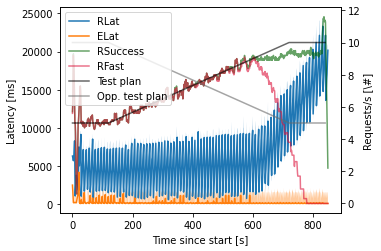

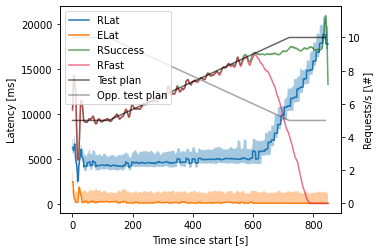

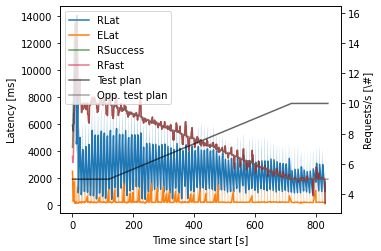

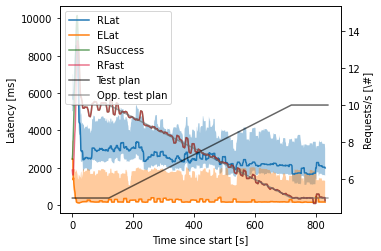

In [24]:
seconds_o, seconds_smooth_o = generate_seconds(onnx)
seconds_o2, seconds_smooth_o2 = generate_seconds(onnx2)
if True:
    plot_seconds(seconds_o)
    #plt.savefig(images_folder + "latency_o1.pgf", dpi=1200)
    plot_seconds(seconds_smooth_o)
    #plt.savefig(images_folder + "latency_smooth_o1.pgf", dpi=1200)
    plot_seconds(seconds_o2)
    #plt.savefig(images_folder + "latency_o2.pgf", dpi=1200)
    plot_seconds(seconds_smooth_o2)
    #plt.savefig(images_folder + "latency_smooth_o2.pgf", dpi=1200)

In [25]:
if True:
    print_stats(onnx)
    print_stats(onnx2)

Total requests: 6279
Inference: mean=336.23824375490983, std=513.6077882841059
Total Duration: mean=7795.988214683867, std=4784.177702203172
Total Computation (inference+upload): mean=341.52906513776077, std=525.6444774451859
Time from invocation to start_computation: mean=7400.203376333811, std=4826.2508741305555
Percentiles for RLat and ELat:
               rlat  result.metadata.inference_ms
count   6279.000000                   6279.000000
mean    7795.988215                    336.238244
std     4784.177702                    513.607788
min      286.000000                     84.616184
50%     6876.000000                     89.024305
90%    15638.800000                   1526.974869
99%    21199.300000                   2036.904249
max    24566.000000                   4187.629938

Total requests: 6318
Inference: mean=449.35146978890907, std=619.1767162037293
Total Duration: mean=2906.4452358341246, std=1670.6056263718317
Total Computation (inference+upload): mean=455.827951883507

In [ ]:
seconds

In [ ]:
#seconds.loc[seconds['rlat_min'] > 0 & seconds['rlat_min'] < 10000]

In [ ]:
def figsize(scale):
    fig_width_pt = 393.1                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

figsize(1)

In [ ]:
seconds_smooth

In [ ]:
trps